## Question and Answering with Knowledge Base(Retrieval Augmented Generation) and LangChain

In [1]:
import os
import openai
import sys
#sys.path.append('../..')

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file

openai.api_key  = os.environ['OPENAI_API_KEY']

## Basic use of LangChain

In [30]:
from langchain.chains import LLMChain
from langchain.llms import OpenAI
from langchain.prompts import PromptTemplate

In [33]:
llm = OpenAI(model= 'text-davinci-003',
            temperature=0.8,
            max_tokens = 256)

In [34]:
prompt = PromptTemplate(
    input_variables = ["product"],
    template = "What is a good name for a company that makes {product}?",
)

llm_chain = LLMChain(llm = llm,
                    prompt = prompt)

In [35]:
print(llm_chain.run({'product': 'AI applications'}))



SmartBrain Technologies


## Loading Document

In [2]:
from langchain.document_loaders import PyPDFLoader

loader = PyPDFLoader("docs/Northwind_Health_Plus_Benefits_Details.pdf")
pages = loader.load()

- Each page is extracted as a single document.
- A Document contains text(page_content) and metadata

In [3]:
# number of pages in the pdf
len(pages)

109

In [4]:
# page content
pages[1]

Document(page_content='This document contains information generated using a language model (Azure OpenAI ). The \ninformation contained in this document is only for demonstration purposes and does not \nreflect the opinions or beliefs of Microsoft. Microsoft makes no representations or \nwarranties of any kind, express or implied, about the completeness, accuracy, reliability, \nsuitability or availability with respect to the information contained in this document.  \nAll rights reserved to Microsoft  \n  ', metadata={'source': 'docs/Northwind_Health_Plus_Benefits_Details.pdf', 'page': 1})

## Document Splitting

In [5]:
from langchain.text_splitter import RecursiveCharacterTextSplitter, CharacterTextSplitter
from langchain.text_splitter import TokenTextSplitter

In [6]:
chunk_size = 500
chunk_overlap = 50

In [7]:
#text_splitter = RecursiveCharacterTextSplitter(
#    chunk_size=chunk_size,
#    chunk_overlap=chunk_overlap,
#    separators=["\n\n", "\n", " ", ""]
#)

In [6]:
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    encoding_name="p50k_base",
    chunk_size = chunk_size,
    chunk_overlap = chunk_overlap,
    separators=["\n\n", "\n", " ", ""]
                
)

In [7]:
splits = text_splitter.split_documents(pages)

In [8]:
len(splits)

208

In [9]:
splits[4]

Document(page_content='Tips:  \n• Make sure to double -check if a provider is in -network or out -of-network before you \nreceive care. This will help you av oid any surprise costs.  \n• Take advantage of preventive care services when they are offered. These services are \ncovered at no cost to you and can help you stay healthy.  \n• Be aware of your plan’s formulary, which is a list of medications that are covered by your \nplan. If you are p rescribed a medication that is not on the formulary, you may have to pay \nmore out -of-pocket.  \n• If you have any questions about your costs, you can contact Northwind Health for more \ninformation.  \nHOW PROVIDERS AFFECT YOUR COSTS  \nIn-Network Providers  \nHOW PROV IDERS AFFECT YOUR COSTS  \nChoosing the right provider is an important part of getting the most value out of your health \ninsurance plan. With Northwind Health Plus, you have access to an extensive network of in -\nnetwork providers. Working with these providers is an essential

In [10]:
# update source metadata to include page numbers

for split in splits:
    new_metadata = {"source":f'{split.metadata["source"].split("/")[1]}/page={split.metadata["page"]}',
                   "page": split.metadata["page"]}
    split.metadata = new_metadata

In [11]:
splits[0].metadata

{'source': 'Northwind_Health_Plus_Benefits_Details.pdf/page=0', 'page': 0}

## VectoreStore and Embeddings

In [12]:
from langchain.vectorstores import Chroma
from langchain.embeddings.openai import OpenAIEmbeddings

In [14]:
embedding = OpenAIEmbeddings(model = "text-embedding-ada-002")

In [16]:
# path to store the cectordb
db_path = "docs/chroma"

In [23]:
# remove existing vectordb if exists

import shutil
if os.path.exists(db_path):
    shutil.rmtree(db_path)

In [24]:
# create vectordb

vectordb = Chroma.from_documents(
    documents = splits,
    embedding = embedding,
    persist_directory = db_path
)

In [17]:
# load vectordb from the persist directory

vectordb = Chroma(persist_directory = db_path, 
                  embedding_function = embedding)

print(vectordb._collection.count())

208


## Retreival

#### Search Types
- Similarity Search
- Max Marginal Relevance Search

In [18]:
query = "What does Northwind Health Plus offer?"

In [27]:
# similarity search
sim_docs = vectordb.similarity_search(query = query, k = 2)

for doc in sim_docs:
    print(doc)
    print("========================================")

page_content='Northwind Health Plus is a comprehensive health plan that offers coverage for medical, \nvision, and dental services. It also provides  coverage for prescription drugs, mental health \nand substance abuse services, and preventive care. You can choose from a variety of in -\nnetwork providers, including primary care physicians, specialists, hospitals, and \npharmacies. Emergency services are also  covered, both in -network and out -of-network.  \nCo-pays, deductibles, and out -of-pocket maximums may apply to your plan. Your plan may \nalso include separate deductibles for different services, such as prescription drugs and \nhospitalization. It is important to know what your plan covers and what the cost -sharing \nrequirements are. To get more information, please visit the Northwind Health website or \ncontact them directly.  \nIt is also important to remember that there may be certain exceptions or limitations in the \nplan. For instance, some plans may not cover certain 

In [28]:
# max marginal relevance
mmr_docs = vectordb.max_marginal_relevance_search(query = query, k = 3)

for doc in mmr_docs:
    print(doc)
    print("============================================")

page_content='Northwind Health Plus is a comprehensive health plan that offers coverage for medical, \nvision, and dental services. It also provides  coverage for prescription drugs, mental health \nand substance abuse services, and preventive care. You can choose from a variety of in -\nnetwork providers, including primary care physicians, specialists, hospitals, and \npharmacies. Emergency services are also  covered, both in -network and out -of-network.  \nCo-pays, deductibles, and out -of-pocket maximums may apply to your plan. Your plan may \nalso include separate deductibles for different services, such as prescription drugs and \nhospitalization. It is important to know what your plan covers and what the cost -sharing \nrequirements are. To get more information, please visit the Northwind Health website or \ncontact them directly.  \nIt is also important to remember that there may be certain exceptions or limitations in the \nplan. For instance, some plans may not cover certain 

### Enhancing the Retrieval

- Filtering
- Self Query Retrieval
- Compression

In [29]:
# retrieval with filter
filter_docs = vectordb.similarity_search(query = query, 
                           k = 2,
                           filter={"page":16})

for doc in filter_docs:
    print(doc)
    print("===========================================")

page_content='Northwind Health Plus is a comprehensive health plan that offers coverage for medical, \nvision, and dental services. It also provides  coverage for prescription drugs, mental health \nand substance abuse services, and preventive care. You can choose from a variety of in -\nnetwork providers, including primary care physicians, specialists, hospitals, and \npharmacies. Emergency services are also  covered, both in -network and out -of-network.  \nCo-pays, deductibles, and out -of-pocket maximums may apply to your plan. Your plan may \nalso include separate deductibles for different services, such as prescription drugs and \nhospitalization. It is important to know what your plan covers and what the cost -sharing \nrequirements are. To get more information, please visit the Northwind Health website or \ncontact them directly.  \nIt is also important to remember that there may be certain exceptions or limitations in the \nplan. For instance, some plans may not cover certain 

In [8]:
# self query retrieval

from langchain.llms import OpenAI
from langchain.retrievers.self_query.base import SelfQueryRetriever
from langchain.chains.query_constructor.base import AttributeInfo

In [18]:
metadata_field_info = [
    AttributeInfo(
        name="source",
        description="The pdf document the text chunk is from, should be have `.pdf` extension",
        type="string",
    ),
    AttributeInfo(
        name="page",
        description="The page from the pdf",
        type="integer",
    )
]

In [24]:
llm = OpenAI(model= 'text-davinci-003',
            temperature=0,
            max_tokens = 256)

retriever = SelfQueryRetriever.from_llm(
    llm = llm,
    vectorstore = vectordb,
    document_contents = "Northwind Health Plan documents",
    metadata_field_info = metadata_field_info,
    verbose = True
)

In [25]:
query = "what is mentioned about Northwind Helath Plan in the second page?"

docs = retriever.get_relevant_documents(query)

C:\Users\ajay.byanjankar\Anaconda3\envs\langchain\Lib\site-packages\langchain\chains\llm.py:279: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


query='Northwind Health Plan' filter=Comparison(comparator=<Comparator.EQ: 'eq'>, attribute='page', value=2) limit=None


In [26]:
for doc in docs:
    print(doc)
    print("========================================")

page_content='Summary of Benefits  \nNorthwind Health Plus  \nNorthwind Health Plus is a comprehensive plan that provides comprehensive cov erage for \nmedical, vision, and dental services. This plan also offers prescription drug coverage, mental \nhealth and substance abuse coverage, and coverage for preventive care services. With \nNorthwind Health Plus, you can choose from a variety of in -network  providers, including \nprimary care physicians, specialists, hospitals, and pharmacies. This plan also offers \ncoverage for emergency services, both in -network and out -of-network.  \nSUMMARY OF YOUR COSTS  \nSUMMARY OF YOUR COSTS  \nAt Northwind Health, we understand  that health care costs can be a burden. That’s why we \noffer a comprehensive plan that covers the cost of medical, vision, and dental services. With \nNorthwind Health Plus, you can choose from a variety of in -network providers, including \nprimary care physic ians, specialists, hospitals, and pharmacies. This plan also

## Question Answering

### RetrievalQA Chain

In [20]:
from langchain.chat_models import ChatOpenAI
from langchain.chains import RetrievalQA

In [21]:
model = "gpt-3.5-turbo"

llm = ChatOpenAI(model = model,
                temperature = 0)

In [22]:
qa_chain = RetrievalQA.from_chain_type(
    llm = llm,
    retriever = vectordb.as_retriever(search_type = "similarity",
                                     search_kwargs = {'k':2})
)

In [23]:
# # prompt
print(qa_chain.combine_documents_chain.llm_chain.prompt.messages[0].prompt.template)

Use the following pieces of context to answer the users question. 
If you don't know the answer, just say that you don't know, don't try to make up an answer.
----------------
{context}


In [24]:
from langchain.prompts import PromptTemplate

template = """Use the following pieces of context to answer the question at the end. If you don't know the answer, 
            just say that you don't know, don't try to make up an answer. 
            Keep the answer as concise as possible. Always say "thanks for asking!" at the end of the answer. 
{context}
Question: {question}
Helpful Answer:"""

QA_CHAIN_PROMPT = PromptTemplate(input_variables=["context", "question"],
                                 template=template)


qa_chain = RetrievalQA.from_chain_type(
    llm = llm,
    chain_type = 'stuff',
    retriever = vectordb.as_retriever(search_type = "similarity",
                                     search_kwargs = {'k':2},
                                     chain_type_kwargs={"prompt": QA_CHAIN_PROMPT}
                                     )
)

In [32]:
# make query
query = "What are some of the best offers provided by Northwind Health Plus?"

response = qa_chain.run(query)

In [34]:
print(response)

Some of the best offers provided by Northwind Health Plus include:

1. Personal Health Support Programs: Northwind Health Plus offers various personal health support programs such as case management, disease management, and wellness programs. These programs provide members with support, information, and resources to help them stay healthy and manage their healthcare costs.

2. Comprehensive Coverage: Northwind Health Plus offers coverage for medical, vision, and dental services. It also covers prescription drugs, mental health and substance abuse services, and preventive care. Emergency services are covered both in-network and out-of-network.

3. Variety of In-Network Providers: Members have the option to choose from a variety of in-network providers, including primary care physicians, specialists, hospitals, and pharmacies. This allows for greater flexibility in accessing healthcare services.

4. Co-pays, Deductibles, and Out-of-Pocket Maximums: While there may be cost-sharing require

### RetrievalQA Chain Types
- Stuff
- Map Reduce
- Refine
- Map Rerank

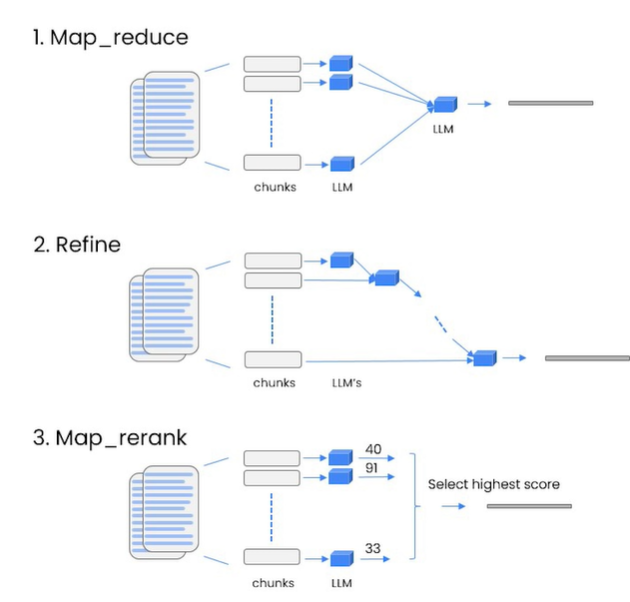

In [ ]:
qa_chain_mr = RetrievalQA.from_chain_type(
    llm,
    retriever=vectordb.as_retriever(),
    chain_type="map_reduce"
)

### RetrievalQA with Sources

In [30]:
from langchain.chains import RetrievalQAWithSourcesChain

qa_with_sources = RetrievalQAWithSourcesChain.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=vectordb.as_retriever(search_type = "similarity",
                                     search_kwargs = {'k':2})
)

In [36]:
qa_with_sources(query)

{'question': 'What are some of the best offers provided by Northwind Health Plus?',
 'answer': 'Some of the best offers provided by Northwind Health Plus include personal health support programs such as case management, disease management, and wellness programs. These programs offer support, information, and resources to help members stay healthy and manage their healthcare costs. Additionally, Northwind Health Plus offers coverage for medical, vision, and dental services, prescription drugs, mental health and substance abuse services, and preventive care. However, it is important to note that the availability of these programs and services may vary depending on the area and the specific plan. It is recommended to contact Northwind Health Plus directly or visit their website for more information on the coverage and benefits provided. \n',
 'sources': 'Northwind_Health_Plus_Benefits_Details.pdf/page=72, Northwind_Health_Plus_Benefits_Details.pdf/page=16'}

## ConversationalRetrieval Chain - Chat Bots

### Memory
- ConversationalBufferMemory
- ConversationalBufferWindowMemory
- ConversationSummaryMemory
- ConversationSummaryBufferMemory

In [25]:
from langchain.chains import ConversationalRetrievalChain
from langchain.memory import ConversationBufferMemory

memory = ConversationBufferMemory(
    memory_key="chat_history",
    return_messages=True
)

In [38]:
retriever = vectordb.as_retriever(search_type = "similarity",
                                  search_kwargs = {'k':2})

chat = ConversationalRetrievalChain.from_llm(
    llm = llm,
    retriever = retriever,
    chain_type = "stuff",
    memory = memory
)

In [39]:
query = "What is Northwind Health Plus for?"
response = chat.run(query)

In [40]:
print(response)

Northwind Health Plus is a comprehensive health plan that offers coverage for medical, vision, and dental services. It also provides coverage for prescription drugs, mental health and substance abuse services, and preventive care.


In [53]:
chat.memory.chat_memory.messages

[HumanMessage(content='What is Northwind Health Plus for?', additional_kwargs={}, example=False),
 AIMessage(content='Northwind Health Plus is a comprehensive health plan that offers coverage for medical, vision, and dental services. It also provides coverage for prescription drugs, mental health and substance abuse services, and preventive care.', additional_kwargs={}, example=False)]

In [54]:
query = "what does it cover for dental services?"
response = chat.run(query)

In [55]:
print(response)

Northwind Health Plus covers services related to the administration of anesthesia in a facility, including spinals, epidurals, and general anesthetics. However, it does not cover dental services such as cosmetic procedures (teeth whitening or veneers) or services that are not medically necessary to relieve pain resulting from dental injury. It also does not cover services provided outside of a facility.


In [56]:
chat.memory.chat_memory.messages

[HumanMessage(content='What is Northwind Health Plus for?', additional_kwargs={}, example=False),
 AIMessage(content='Northwind Health Plus is a comprehensive health plan that offers coverage for medical, vision, and dental services. It also provides coverage for prescription drugs, mental health and substance abuse services, and preventive care.', additional_kwargs={}, example=False),
 HumanMessage(content='what does it cover for dental services?', additional_kwargs={}, example=False),
 AIMessage(content='Northwind Health Plus covers services related to the administration of anesthesia in a facility, including spinals, epidurals, and general anesthetics. However, it does not cover dental services such as cosmetic procedures (teeth whitening or veneers) or services that are not medically necessary to relieve pain resulting from dental injury. It also does not cover services provided outside of a facility.', additional_kwargs={}, example=False)]

In [57]:
query = "How expensive is the cost?"
response = chat.run(query)

In [58]:
print(response)

The cost of Northwind Health Plus will depend on your plan type, the services you use, and the providers you visit. The specific costs, such as premiums, deductibles, and co-pays, can vary and may change from year to year. It is recommended to review your plan documents or visit the Northwind Health website for more information on cost-sharing arrangements.


In [59]:
chat.memory.chat_memory.messages

[HumanMessage(content='What is Northwind Health Plus for?', additional_kwargs={}, example=False),
 AIMessage(content='Northwind Health Plus is a comprehensive health plan that offers coverage for medical, vision, and dental services. It also provides coverage for prescription drugs, mental health and substance abuse services, and preventive care.', additional_kwargs={}, example=False),
 HumanMessage(content='what does it cover for dental services?', additional_kwargs={}, example=False),
 AIMessage(content='Northwind Health Plus covers services related to the administration of anesthesia in a facility, including spinals, epidurals, and general anesthetics. However, it does not cover dental services such as cosmetic procedures (teeth whitening or veneers) or services that are not medically necessary to relieve pain resulting from dental injury. It also does not cover services provided outside of a facility.', additional_kwargs={}, example=False),
 HumanMessage(content='How expensive is t

In [37]:
import langchain
print(langchain.__version__)

0.0.265


In [38]:
import openai
print(openai.__version__)

0.27.8
